In [2]:
import pandas as pd

In [3]:
import os

DATA_DIR = 'data/train-scene classification'
MODEL_DIR = "models"

IMG_DIR = os.path.join(DATA_DIR, 'train')

TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
TEST_CSV = "data/test_WyRytb0.csv"

image = 'image_name'
label = 'label'

H = W = 150
ORIG_H = ORIG_W = 150

In [4]:
train_data = pd.read_csv(TRAIN_CSV)
train_data.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [5]:
train_data[label].value_counts()

3    3037
2    2957
5    2883
4    2784
1    2745
0    2628
Name: label, dtype: int64

In [6]:
test_data = pd.read_csv(TEST_CSV)

In [7]:
from PIL import Image
img = Image.open("data/train-scene classification/train/"+"2.jpg")
img.size

(150, 150)

In [8]:
# for i,row in train_data.iterrows():
#     img = Image.open("data/train-scene classification/train/"+row["image_name"])
#     if img.size!=(150,150):
#         print(row["image_name"],img.size)

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision.transforms.functional as Func
from torch.utils import data
from torchvision import transforms, utils

import tqdm
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

class AVDataset(data.Dataset):
    def __init__(self, IMG_DIR, file_list, is_test = False, transform=None):
        self.is_test = is_test
        self.root_path = IMG_DIR
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_path = os.path.join(self.root_path, file_id[0])
        
        image = load_image(image_path)
        if self.transform:
            image = self.transform(image)
            
        if self.is_test==True:
            return image
        else:
            return image,file_id[1]

In [22]:
transforms = transforms.Compose([
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip()
])

In [23]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
def load_image(path):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     print(img.shape)
    if img.shape != (150,150,3):
        img = cv2.resize(img, (150,150), interpolation = cv2.INTER_AREA)
#     print(img.shape)
#     plt.imshow(img)
#     plt.show()
#     if h_flip:
#         img = cv2.flip( img, 1 )
#     if crop:
#         img = random_crop_resize(img,scale=ratio)
    
#     if brightness:
#         img = increase_brightness(img)
    return torch.from_numpy(img).float().permute([2, 0, 1])

In [24]:
load_image(os.path.join(IMG_DIR, "357.jpg")).shape

torch.Size([3, 150, 150])

In [25]:
def create_file_list(dataframe):
    return [tuple(x) for x in dataframe.values]

In [26]:
from sklearn.model_selection import train_test_split
train,val = train_test_split(train_data, test_size=0.05, stratify=train_data[label],random_state=42)
print(train.shape,val.shape)

(16182, 2) (852, 2)


In [27]:
file_list_train = create_file_list(train)
file_list_val = create_file_list(val)

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
    img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
    plt.imshow(img)
    plt.axis('off')

In [29]:
dataset = torch.utils.data.ConcatDataset([AVDataset(IMG_DIR, file_list_train,transform=transforms)])

In [14]:
dataset = torch.utils.data.ConcatDataset([AVDataset(IMG_DIR, file_list_train), AVDataset(IMG_DIR, file_list_train, h_flip=True)])
val_dataset = torch.utils.data.ConcatDataset([AVDataset(IMG_DIR, file_list_val),  AVDataset(IMG_DIR, file_list_val, h_flip=True)])
len(dataset)

32364

In [15]:
import torch
from torch import nn
from pathlib import Path
from torch.nn import functional as F
from torchvision import models
from torchvision.transforms import ToTensor, Normalize, Compose
import cv2
from pathlib import Path

In [16]:
from cnn_finetune import make_model
model = make_model('resnet34', num_classes=6, pretrained=True, input_size=(150, 150))

In [17]:
import torch
from torchvision import models
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = model.to(device)

summary(vgg, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14           [-1, 64,

In [18]:
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
# criterion = nn.CrossEntropyLoss()
# m = nn.LogSoftmax()
criterion =  nn.CrossEntropyLoss()
epoch=2
for e in range(epoch):
#     learning_rate = cyclic_lr(e)
    print("learning_rate",learning_rate)
    train_loss = []
    train_acc = []
    for image, mask in tqdm.tqdm(data.DataLoader(dataset, batch_size = 16,shuffle=True, num_workers=6)):
        
        optimizer.zero_grad()
        
        image = image.type(torch.FloatTensor).cuda()
        y_pred = model(Variable(image))
        loss = criterion(y_pred, Variable(mask.cuda()))
        
        loss.backward()

        optimizer.step()
        train_loss.append(loss.item())
        
    val_loss = []
    val_acc =[]
    for image, mask in data.DataLoader(val_dataset, batch_size = 8, shuffle = True):
        image = image.cuda()
        y_pred = model(Variable(image))

        loss = criterion(y_pred, Variable(mask.cuda()))
        val_loss.append(loss.item())
        
    print("Epoch: %d, Train loss: %.3f,  Val loss: %.3f" % (e, np.mean(train_loss), np.mean(val_loss)))
#     print("Train acc: %.3f, Val acc: %.3f" %(np.mean(train_acc),np.mean(val_acc)))

  0%|          | 0/2023 [00:00<?, ?it/s]

learning_rate 0.001


  0%|          | 0/2023 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.282,  Val loss: 0.329
learning_rate 0.001


100%|██████████| 2023/2023 [10:00<00:00,  3.37it/s]


Epoch: 1, Train loss: 0.129,  Val loss: 0.327


In [19]:
test_file_list = create_file_list(test_data)
test_file_list[:4]

[('3.jpg',), ('5.jpg',), ('6.jpg',), ('11.jpg',)]

In [20]:
print(len(test_file_list))
test_dataset = AVDataset(IMG_DIR, test_file_list, is_test = True)

7301


In [21]:
all_predictions = []
model.eval()
for image in tqdm.tqdm(data.DataLoader(test_dataset, batch_size = 1)):
    image = image.type(torch.FloatTensor).cuda()
    y_pred = model(Variable(image))#.cpu().data.numpy()
    _,predicted = torch.max(y_pred,1)
#     print(predicted[0].cpu().data.numpy())
    all_predictions.append(predicted[0].cpu().data.numpy())
#     all_predictions.append(y_pred)
# all_predictions_stacked = np.vstack(all_predictions)[:, 0, :, :]

100%|██████████| 7301/7301 [01:35<00:00, 76.29it/s]


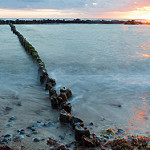

In [22]:
Image.open("data/train-scene classification/train/"+test_file_list[2][0])

In [23]:
def show_img_by_class(df,class_num):
    return Image.open("data/train-scene classification/train/{}".format(df[df["label"]==class_num]["image_name"].values[0]))

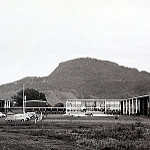

In [24]:
show_img_by_class(train_data,0)

In [25]:
len(all_predictions), all_predictions[:5]

(7301, [array(5), array(0), array(4), array(2), array(5)])

In [26]:
test_data.head()

,image_name
0,3.jpg
1,5.jpg
2,6.jpg
3,11.jpg
4,14.jpg


In [27]:
sub = test_data
sub["label"] = all_predictions

In [28]:
sub.to_csv("rnet34_epo_2_horizontal_aug.csv",index=False)